*Reva Bharara*

*Email : revabharara@gmail.com*

*Linkedin : https://www.linkedin.com/in/reva-bharara-a83a78241/*


### Objective: To make a movie recommendation system based on collaborative filtering using K means clustering.

### *Index:*
1. Importing the dependencies
2. Importing relevant datasets
3. Data exploration
4. Data preprocessing
5. Data analysis
5. Collaborative filtering recommendation system (K-Means)
    1. Forming a movie and user rating matrix so that we can easily cluster the similar users (using pivot table)
    2. K Means clustering (building the model)
    3. Training the model and visualisation
    4. Evaluating the model
6. Insights
7. Credits

### --------------------------------------------------------------------------------------------------------
### *1. Importing the dependencies*

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from scipy.sparse import csr_matrix

### --------------------------------------------------------------------------------------------------------
### *2. Importing relevant datasets*

In [2]:
# importing the movies dataset
df_movies=pd.read_csv('movie_names.csv')

# importing the rating dataset
df_rating=pd.read_csv('rating.csv')

In [3]:
# the dataset is too big so we will be cutting it short for smoother operations
df_rating=df_rating.head(200000)
# df_rating.to_csv('rating.csv')

### --------------------------------------------------------------------------------------------------------
### *3. Exploring the data*

In [4]:
df_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
df_rating.head()

,Unnamed: 0,userId,movieId,rating,timestamp
0,0,1,2,3.5,2005-04-02 23:53:47
1,1,1,29,3.5,2005-04-02 23:31:16
2,2,1,32,3.5,2005-04-02 23:33:39
3,3,1,47,3.5,2005-04-02 23:32:07
4,4,1,50,3.5,2005-04-02 23:29:40


In [6]:
# let us look at the columns present in the datasets and their general features
print(df_movies.columns)
print(df_rating.columns)


Index(['movieId', 'title', 'genres'], dtype='object')
Index(['Unnamed: 0', 'userId', 'movieId', 'rating', 'timestamp'], dtype='object')


In [7]:
print(f'shape of movies dataset: {df_movies.shape}')
print(f'shape of rating dataset: {df_rating.shape}')

shape of movies dataset: (27278, 3)
shape of rating dataset: (200000, 5)


In [8]:
print(f'info about the movies dataset: {df_movies.info()}')
print()
print(f'info about the rating dataset: {df_rating.info()}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27278 entries, 0 to 27277
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  27278 non-null  int64 
 1   title    27278 non-null  object
 2   genres   27278 non-null  object
dtypes: int64(1), object(2)
memory usage: 639.5+ KB
info about the movies dataset: None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Unnamed: 0  200000 non-null  int64  
 1   userId      200000 non-null  int64  
 2   movieId     200000 non-null  int64  
 3   rating      200000 non-null  float64
 4   timestamp   200000 non-null  object 
dtypes: float64(1), int64(3), object(1)
memory usage: 7.6+ MB
info about the rating dataset: None


In [9]:
df_rating.isnull().sum()

Unnamed: 0    0
userId        0
movieId       0
rating        0
timestamp     0
dtype: int64

### --------------------------------------------------------------------------------------------------------
### *4. Data preprocessing*

#### There are no null values in both the dataframes so we dont have to process those.

#### We now need to join the *'title'* and *'genres'* column from df_movies to df_rating and store it


In [10]:
df_rating=df_rating.merge(df_movies, on='movieId')
df_rating.head()

,Unnamed: 0,userId,movieId,rating,timestamp,title,genres
0,0,1,2,3.5,2005-04-02 23:53:47,Jumanji (1995),Adventure|Children|Fantasy
1,451,5,2,3.0,1996-12-25 15:26:09,Jumanji (1995),Adventure|Children|Fantasy
2,1501,13,2,3.0,1996-11-27 08:19:02,Jumanji (1995),Adventure|Children|Fantasy
3,3326,29,2,3.0,1996-06-23 20:36:14,Jumanji (1995),Adventure|Children|Fantasy
4,3904,34,2,3.0,1996-10-28 13:29:44,Jumanji (1995),Adventure|Children|Fantasy


#### We don't need the timestamp column it is of no significance so we will delete it.

In [11]:
df_rating.drop(['timestamp'],axis=1, inplace=True)
df_rating.head()

,Unnamed: 0,userId,movieId,rating,title,genres
0,0,1,2,3.5,Jumanji (1995),Adventure|Children|Fantasy
1,451,5,2,3.0,Jumanji (1995),Adventure|Children|Fantasy
2,1501,13,2,3.0,Jumanji (1995),Adventure|Children|Fantasy
3,3326,29,2,3.0,Jumanji (1995),Adventure|Children|Fantasy
4,3904,34,2,3.0,Jumanji (1995),Adventure|Children|Fantasy


In [12]:
len(df_rating['title'].unique())

10151

In [13]:
# checking if there are any null values still
df_rating.isnull().sum()

Unnamed: 0    0
userId        0
movieId       0
rating        0
title         0
genres        0
dtype: int64

### --------------------------------------------------------------------------------------------------------
### *5. Data Analysis*

#### Now that we have explored and pre-processed the data, we will now analyse it in this section to gather any insights that might help up in out model building process. This involves:
1. finding the average user rating of each movie
2. finding the likebility of each genre
3. number of movies in each genre


#### 1. Finding the average user rating of each movie


#### 2. Finding the likeability of each movie

#### 3. Number of movies in each genre

### --------------------------------------------------------------------------------------------------------
### *5. Collaborative movie recommendation system*

The current content-based recommendation engine we have has significant limitations. It can only suggest movies that are similar to a particular movie and cannot provide recommendations across different genres or capture individual preferences. Additionally, the engine does not take into account the unique tastes and biases of individual users, as it provides the same recommendations to all users who query it for a particular movie.

To overcome these limitations, we will use a technique called Collaborative Filtering, which uses the behavior and preferences of similar users to predict how much a user will like a particular movie that they have not yet watched. This approach leverages the idea that users who have similar preferences can be used to make accurate recommendations and tailor them to each user's individual tastes.

In this collaborative filtering system we will be creating a user-movie rating matrix that will tell us how users rated every movie and from there we will be using the nearest neighbor model to form user clusters and based on those user clusters we will be recommending the movies.
This matrix will tell us how the users have rated a particular movie

In this section we will be 
1. Forming a movie and user rating matrix so that we can easily cluster the similar users (using pivot table)
2. K Means clustering (building the model)
3. Training the model and visualisation
4. Evaluating the model

## 1. Forming the pivot table

In [14]:
rating_pivot=df_rating.pivot_table(columns='userId', index='title', values='rating')
rating_pivot.head()

userId,1,2,3,4,5,6,7,8,9,10,...,1362,1363,1364,1365,1366,1367,1368,1369,1370,1371
title,,,,,,,,,,,,,,,,,,,,,
'Hellboy': The Seeds of Creation (2004),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
'Neath the Arizona Skies (1934),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
'Round Midnight (1986),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
'Salem's Lot (2004),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
'Til There Was You (1997),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Since we cannot process nan values we are going to change them to 0.0

In [15]:
rating_pivot.fillna('0.0', inplace=True)
rating_pivot.head()

userId,1,2,3,4,5,6,7,8,9,10,...,1362,1363,1364,1365,1366,1367,1368,1369,1370,1371
title,,,,,,,,,,,,,,,,,,,,,
'Hellboy': The Seeds of Creation (2004),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
'Neath the Arizona Skies (1934),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
'Round Midnight (1986),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
'Salem's Lot (2004),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
'Til There Was You (1997),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
rating_pivot[1].unique()

array(['0.0', 3.5, 4.0, 3.0, 5.0, 4.5], dtype=object)

In [17]:
#converting the dtype of values into float
rating_pivot=rating_pivot.astype('float')

In [18]:
rating_pivot[1].dtype

dtype('float64')

#### Now since there are a lot of 0 values and they will have no impact on k means clustering (using eucludian distance) to make it more efficint we will be converting the pivot table into a sparce matrix using the scipy module and csr_matrix function.
The SciPy library provides a module called scipy.sparse that implements various types of sparse matrices. One of these matrix formats is the Compressed Sparse Row (CSR) format, which is commonly used for sparse matrix operations in numerical computations.

In [19]:
rating_pivot=csr_matrix(rating_pivot)
rating_pivot

<10151x1371 sparse matrix of type '<class 'numpy.float64'>'
	with 199997 stored elements in Compressed Sparse Row format>

## 2. KMeans clustering
We can group users based on their movie ratings using a user-item rating matrix, where each row represents me as a user and each column represents a movie, with the values in the matrix representing my rating for the corresponding movie.

By treating each row as a data point and using k-means clustering, I can group similar users together based on their ratings, choosing the number of clusters with the elbow method. 

Once the users have been clustered, you can recommend movies to new users by suggesting movies that have been highly rated by users in the same cluster. This approach assumes that users in the same cluster have similar movie preferences, and therefore, are likely to enjoy the same movies.

In [20]:
# initializing the model
kmeans=KMeans(init='k-means++', n_clusters=5, n_init=12)
kmeans

KMeans(n_clusters=5, n_init=12)

In [23]:
# training the model
clusters=kmeans.fit(rating_pivot)
clusters

KMeans(n_clusters=5, n_init=12)


## 3. Visualization of clusters
Now that we have fitted the model we will plot the clusters to see what they look like using matplotlib

TypeError: float() argument must be a string or a real number, not 'KMeans'

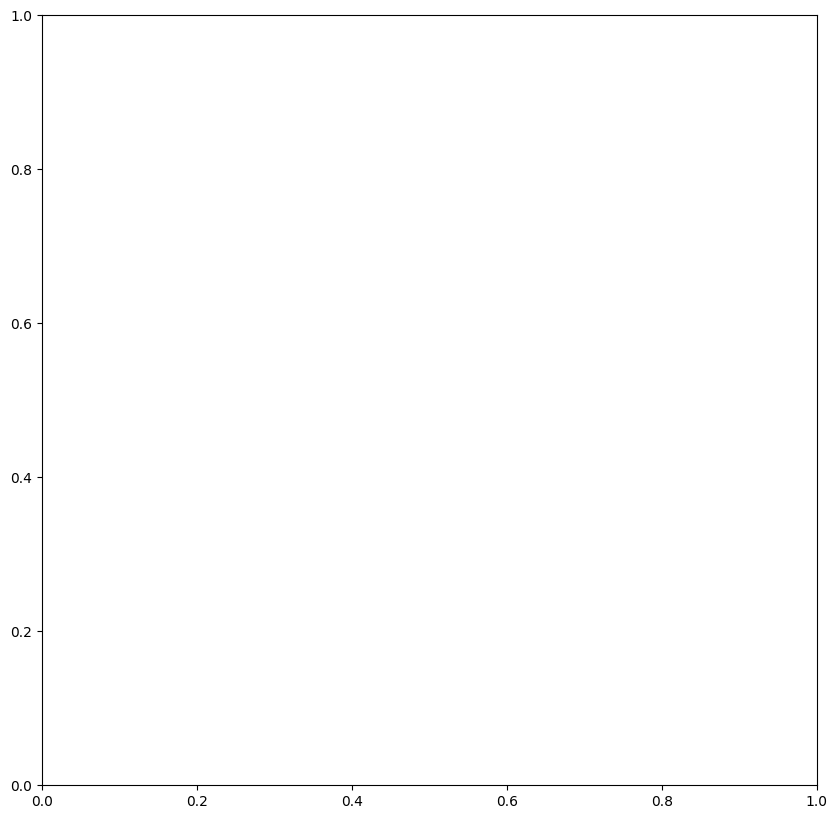

In [22]:
# figure=plt.figure(figsize=(10,10))
# plt.scatter(rating_pivot[:,0], rating_pivot[:,1], c=clusters)
# plt.show()
